risk-free rate is 2%, the underlying stock has the current price 100, and volatility 25 percent,with no dividend payments.<br>  All the options have a strike price 105 and the maturity 3 months. The simulation has the unit time = 1 week.

# Option pricing with Monte Carlo

In [16]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
r=2/100;S_0=100;sig=25/100
K=105;T=3/12;del_t=1/48;
n_simu_time=12
n_scenarios=100000

## a)

In [3]:
price_simu={}
ac_payoff=[];ap_payoff=[];lc_payoff=[]
lp_payoff=[];flc_payoff=[];flp_payoff=[]
for i_sce in range(n_scenarios):
    price_simu[i_sce]=[]
    for i_simt in range(n_simu_time+1):
        if i_simt==0:
            #S_simu=S_0*math.exp((r-(sig**2)/2)*del_t + sig*math.sqrt(del_t)*np.random.normal(0,1))
            price_simu[i_sce].append(S_0)
        else:
            S_simu=price_simu[i_sce][i_simt-1]*(
                np.exp((r-(sig**2)/2)*del_t + sig*np.sqrt(del_t)*np.random.normal(0,1)))
            price_simu[i_sce].append(S_simu)
    p_avg=np.mean(price_simu[i_sce])
    p_max=np.max(price_simu[i_sce])
    p_min=np.min(price_simu[i_sce])
    
    ### Asian call and put
    if p_avg-K<0:
        ap_payoff.append((K-p_avg)*np.exp(-r*T))
        ac_payoff.append(0)
    elif p_avg-K>0:
        ac_payoff.append((p_avg-K)*np.exp(-r*T))
        ap_payoff.append(0)
    else:
        ac_payoff.append(0)
        ap_payoff.append(0)
        
    ### Lookback Call
    if p_max>K:
        lc_payoff.append((p_max-K)*np.exp(-r*T))
    else:
        lc_payoff.append(0)
        
    ### Lookback put
    if p_min<K:
        lp_payoff.append((K-p_min)*np.exp(-r*T))
    else:
        lp_payoff.append(0)
    
    ### Floating Lookback Call
    if S_simu>p_min:
        flc_payoff.append((S_simu-p_min)*np.exp(-r*T))
    else:
        flc_payoff.append(0)
    
    ### Floating Lookback Put
    if p_max>S_simu:
        flp_payoff.append((p_max-S_simu)*np.exp(-r*T))
    else:
        flp_payoff.append(0)

##### get each option mean price:
ac_p=np.mean(ac_payoff);ac_std=np.std(ac_payoff,ddof=1)
ap_p=np.mean(ap_payoff);ap_std=np.std(ap_payoff,ddof=1)
lc_p=np.mean(lc_payoff);lc_std=np.std(lc_payoff,ddof=1)
lp_p=np.mean(lp_payoff);lp_std=np.std(lp_payoff,ddof=1)
flc_p=np.mean(flc_payoff);flc_std=np.std(flc_payoff,ddof=1)
flp_p=np.mean(flp_payoff);flp_std=np.std(flp_payoff,ddof=1)

option_mean=[ac_p,ap_p,lc_p,lp_p,flc_p,flp_p]
option_std=[ac_std,ap_std,lc_std,lp_std,flc_std,flp_std]
option_name=['Asian call','Asian put','Lookback call','Lookback put',
            'Floating lookback call','Floating lookback put']
for i in range(6):
    print('The value of {0} is: {1}'.format(option_name[i],round(option_mean[i],4)))
    print('Interval of',option_name[i],'is [{0},{1}] with confident level 95%'
          .format(round(option_mean[i]-1.96*option_std[i]/np.sqrt(n_scenarios),4),
                  round(option_mean[i]+1.96*option_std[i]/np.sqrt(n_scenarios),4)))
    print()

The value of Asian call is: 1.1413
Interval of Asian call is [1.1238,1.1587] with confident level 95%

The value of Asian put is: 5.863
Interval of Asian put is [5.8295,5.8965] with confident level 95%

The value of Lookback call is: 5.0316
Interval of Lookback call is [4.9872,5.076] with confident level 95%

The value of Lookback put is: 12.5908
Interval of Lookback put is [12.5493,12.6324] with confident level 95%

The value of Floating lookback call is: 8.0987
Interval of Floating lookback call is [8.0482,8.1491] with confident level 95%

The value of Floating lookback put is: 8.0613
Interval of Floating lookback put is [8.0183,8.1043] with confident level 95%



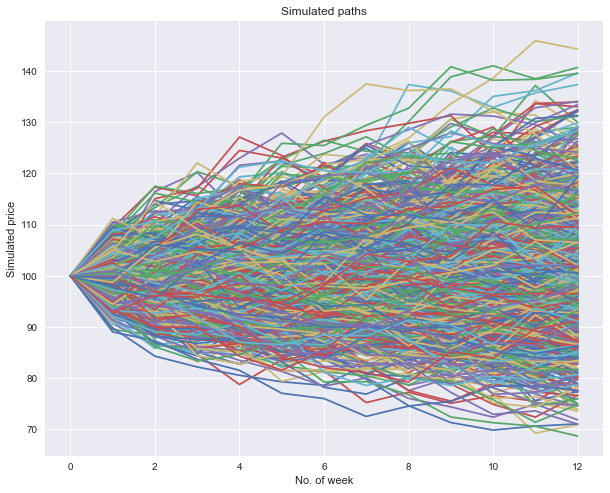

<Figure size 432x288 with 0 Axes>

In [24]:
sns.set()
x_axis=np.arange(13)
plt.figure(figsize=(10,8))
for k in range(1000):
    plt.plot(x_axis,price_simu[k])
plt.title('Simulated paths')
plt.xlabel('No. of week')
plt.ylabel('Simulated price')
plt.show()
plt.savefig("SIM_Paths.png")

## b):American put option pricing

In [4]:
total_st=[]
total_payoff=[]
for i_sce in tqdm(range(n_scenarios)):
    stop_time=None
    for i_simt in np.arange(n_simu_time+1):
        ### Remaining time for current simulation
        remain_time=T-i_simt*del_t
        
        ### Initiate spot price of underlying asset
        if i_simt==0:
            S_current=S_0
        else:
            S_current=S_current*np.exp((r-(sig**2)/2)*del_t 
                                         + sig*np.sqrt(del_t)*np.random.normal(0,1))
        ### Calculate d1 and d2
        ### Calculate put option premium
        if remain_time != 0:
            d_1=(np.log(S_current/K)+(r+(sig**2)/2)*remain_time)/(sig*np.sqrt(remain_time))
            d_2=d_1-(sig*np.sqrt(remain_time))
        else:
            if S_current<K:
                d_1=-np.inf
                d_2=d_1
            else:
                d_1=np.inf
                d_2=d_1
                
        p_premium=K*np.exp(-r*remain_time)*norm.cdf(-d_2,0,1)-S_current*norm.cdf(-d_1,0,1)    
        ### Compute option payoff at current time
        if K>S_current:
            curr_payoff=K-S_current
        else:
            curr_payoff=0
        
        ### Compute optimal execrise time
        if curr_payoff<p_premium:
            pass
        else:
            stop_time=i_simt*del_t
            break
                
    if stop_time==None:
        stop_time=T
                
    total_st.append(stop_time)
    present_payoff=curr_payoff*np.exp(-r*stop_time)
    total_payoff.append(present_payoff)   
    
    
avg_stoptime=np.mean(total_st) ### Average stop time
stoptime_std=np.std(total_st,ddof=1) ### Standard deviation of stop time
avg_payoff=np.mean(total_payoff) ### Average payoff
payoff_std=np.std(total_payoff,ddof=1) ### Standard deviation of payoff
    
print('The estimated stopping time is {0}, \n Along with 95% confidence interval, which is [{1},{2}]'
      .format(round(avg_stoptime,4),round(avg_stoptime-1.96*stoptime_std/np.sqrt(n_scenarios),4),
              round(avg_stoptime+1.96*stoptime_std/np.sqrt(n_scenarios),4)))
print()
print('The estimated American put option price is {0}, \n Along with 95% confidence interval, which is [{1},{2}]'
      .format(round(avg_payoff,4),round(avg_payoff-1.96*payoff_std/np.sqrt(n_scenarios),4),
              round(avg_payoff+1.96*payoff_std/np.sqrt(n_scenarios),4)))

100%|██████████| 100000/100000 [03:50<00:00, 433.27it/s]

The estimated stopping time is 0.1993, 
 Along with 95% confidence interval, which is [0.199,0.1997]

The estimated American put option price is 7.6772, 
 Along with 95% confidence interval, which is [7.6353,7.7191]


# Option pricing using lattice

In [5]:
u=np.exp(sig*np.sqrt(del_t))
d=np.exp(-sig*np.sqrt(del_t))
R=np.exp(r*del_t)
q=(R-d)/(u-d)
q_m=1-q

## C)

In [6]:
la_paths=np.zeros((2**n_simu_time,n_simu_time+1))
la_paths

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
for i in range(1,n_simu_time+1):
    n_split=2**i
    interval=int((2**n_simu_time)/n_split)
    for i_split in range(n_split):
        if i_split%2==0:
            la_paths[i_split*interval:,i]=1
        else:
            la_paths[i_split*interval:,i]=-1
            
la_paths[la_paths==1]=u
la_paths[la_paths==-1]=d
la_paths[la_paths==0]=S_0
final_paths=la_paths.cumprod(axis=1)

### Asian call and put
means_paths=final_paths.mean(axis=1)
ac=means_paths.copy()
ap=means_paths.copy()
ac=ac-K
ac[ac<0]=0
ac=ac*np.exp(-r*T)
ap=K-ap
ap[ap<0]=0
ap=ap*np.exp(-r*T)
la_ac=ac.mean()
la_ap=ap.mean()

### Lookback call and put
max_paths=final_paths.max(axis=1)
min_paths=final_paths.min(axis=1)
lbc=max_paths-K
lbc[lbc<0]=0
lbc=lbc*np.exp(-r*T)
lbp=K-min_paths
lbp[lbp<0]=0
lbp=lbp*np.exp(-r*T)
la_lbc=lbc.mean()
la_lbp=lbp.mean()

### Floating looback call and put
S_maturity=final_paths[:,-1].copy()
flbc=S_maturity-min_paths
flbp=max_paths-S_maturity
flbc[flbc<0]=0
flbp[flbp<0]=0
flbc=flbc*np.exp(-r*T)
flbp=flbp*np.exp(-r*T)
la_flbc=flbc.mean()
la_flbp=flbp.mean()

option_mean=[la_ac,la_ap,la_lbc,la_lbp,la_flbc,la_flbp]
option_name=['Asian call','Asian put','Lookback call','Lookback put',
            'Floating lookback call','Floating lookback put']

for i in range(6):
    print('The value of {0} is: {1}'.format(option_name[i],round(option_mean[i],4)))

The value of Asian call is: 1.1818
The value of Asian put is: 5.7672
The value of Lookback call is: 5.4003
The value of Lookback put is: 12.7146
The value of Floating lookback call is: 8.5197
The value of Floating lookback put is: 8.2178


## d)

In [8]:
dic_sim_asset={}
dic_sim_payoff={}
for i_simt in np.arange(12,-1,-1):
    dic_sim_asset[i_simt]=[]
    dic_sim_payoff[i_simt]=[]
    
    if i_simt==12:
        for i in range(i_simt+1):
            S=S_0*(d**i)*(u**(i_simt-i))
            dic_sim_asset[i_simt].append(S)
            if K>S:
                dic_sim_payoff[i_simt].append(K-S)
            else:
                dic_sim_payoff[i_simt].append(0)
                
    elif i_simt!=0:
        for i in range(i_simt+1):
            S=S_0*(d**i)*(u**(i_simt-i))
            dic_sim_asset[i_simt].append(S)
            if K>S:
                curr_payoff=K-S
            else:
                curr_payoff=0
                
            wait_payoff=(1/R)*(q*dic_sim_payoff[i_simt+1][i] + q_m*dic_sim_payoff[i_simt+1][i+1])
            dic_sim_payoff[i_simt].append(max([curr_payoff,wait_payoff]))
    else:
        p_amer_put=(1/R)*(q*dic_sim_payoff[i_simt+1][0] + q_m*dic_sim_payoff[i_simt+1][1])
        dic_sim_payoff[i_simt].append(p_amer_put)


print('The American put option value estimated by lattice approach is:',round(dic_sim_payoff[0][0],4))

The American put option value estimated by lattice approach is: 7.7836


In [9]:
a=pd.DataFrame(final_paths)
a.to_excel('lat_path.xlsx')